In [1]:
import numpy as np
import tensorflow as tf
import datetime
import os
import checkpoint_test

memory growth: True


In [2]:
iterations = 4000
batch_size = 256
sample_interval = 800

accur = tf.metrics.CategoricalAccuracy()

In [3]:
sgan = checkpoint_test.SGAN()

In [4]:

checkpoint_dir = './checkpoint/sgan'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "sgan")
root = tf.train.Checkpoint(disc_optimizer=sgan.discriminator_optimizer,
                           disc_model=sgan.discriminator_supervised,
                           gen_optimizer=sgan.generator_optimizer,
                           gen_model=sgan.generator)

#root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [5]:
model2 = sgan.generator
optimizer2 = tf.keras.optimizers.Adam()

In [6]:
checkpoint_dir = './checkpoint/sgan_gen'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "sgan_gen")
root = tf.train.Checkpoint(optimizer=optimizer2,
                           model=model2)

#root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [7]:
x_train, y_train = sgan.dataset.training_set()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=sgan.num_classes)
x_test, y_test = sgan.dataset.test_set()
y_test = tf.keras.utils.to_categorical(y_test, num_classes=sgan.num_classes)

In [8]:
# トレーニングデータの分類精度を計算する
y_out = sgan.discriminator_supervised(x_train)
accur.update_state(y_train,y_out)
print("Training Accuracy: %.2f%%" % (100 * accur.result()))
accur.reset_states()

y_out = sgan.discriminator_supervised(x_test)
accur.update_state(y_test,y_out)
print("Test Accuracy: %.2f%%" % (100 * accur.result()))
accur.reset_states()

Training Accuracy: 100.00%
Test Accuracy: 89.14%


In [9]:
sgan.discriminator_supervised.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                113930    
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 113,930
Trainable params: 113,546
Non-trainable params: 384
_________________________________________________________________


In [10]:
sgan.discriminator_supervised.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         5

In [11]:
arr = []
names = [l.name for l in sgan.discriminator_supervised.layers[0].layers]
print(names)

['conv2d', 'leaky_re_lu', 'conv2d_1', 'batch_normalization', 'leaky_re_lu_1', 'conv2d_2', 'batch_normalization_1', 'leaky_re_lu_2', 'dropout', 'flatten', 'dense']


In [12]:
model = sgan.discriminator_supervised.layers[0]
hidden_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer("conv2d_1").output)

In [13]:
hidden_output = hidden_layer_model.predict(x_train[0:1,:,:,:])
print(hidden_output.shape)
w = hidden_output

(1, 7, 7, 64)


In [14]:
w_scale = ((w - w.min()) / (w.max() - w.min()) * 255).astype('uint8')
print(w_scale.min(), w_scale.max())

0 255


In [15]:
w_transpose = w_scale.transpose(3, 0, 1, 2)
print(w_transpose.shape)
w_transpose = np.squeeze(w_transpose)
print(w_transpose.shape)

(64, 1, 7, 7)
(64, 7, 7)


In [16]:
import cv2
def img_marge(img,x,y):
    hcon_images = []
    for i in range(y):
        hcon_images.append(np.concatenate(img[x * i :x * (i+1),:,:], axis=1))
    return np.concatenate(hcon_images, axis=0)

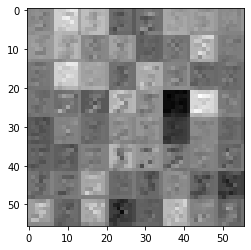

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

img = img_marge(w_transpose,8,8)
plt.imshow(img, cmap = "gray")

conv2d
(32, 14, 14)
2


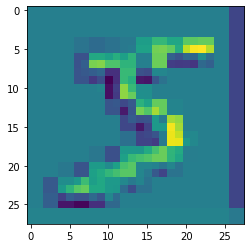

leaky_re_lu
(32, 14, 14)
2


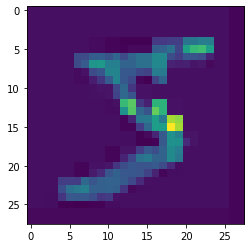

conv2d_1
(64, 7, 7)
4


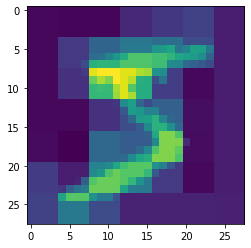

batch_normalization
(64, 7, 7)
4


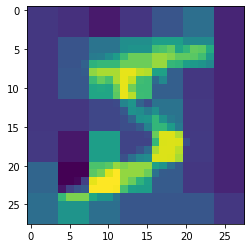

leaky_re_lu_1
(64, 7, 7)
4


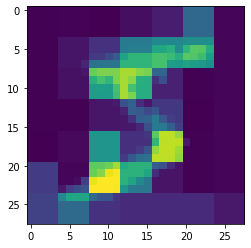

conv2d_2
(128, 4, 4)
7


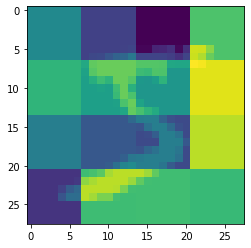

batch_normalization_1
(128, 4, 4)
7


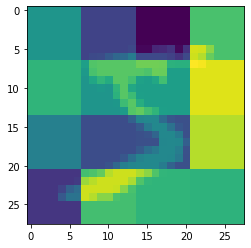

leaky_re_lu_2
(128, 4, 4)
7


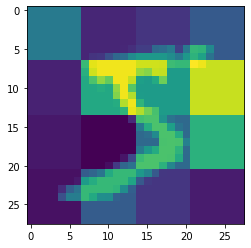

dropout
(128, 4, 4)
7


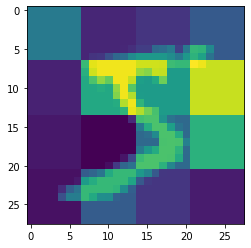

flatten


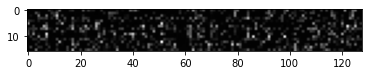

dense


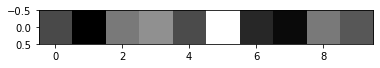

In [18]:
import show_hidden_outputs

show_hidden_outputs.marge_hidden_outputs(sgan.discriminator_supervised.layers[0],x_train[0:1,:,:,:])

conv2d
(32, 14, 14)
2


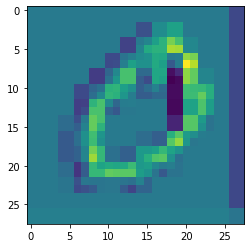

leaky_re_lu
(32, 14, 14)
2


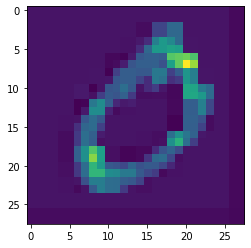

conv2d_1
(64, 7, 7)
4


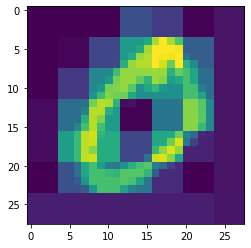

batch_normalization
(64, 7, 7)
4


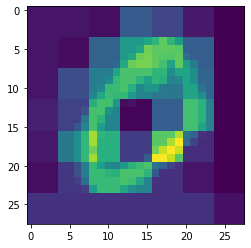

leaky_re_lu_1
(64, 7, 7)
4


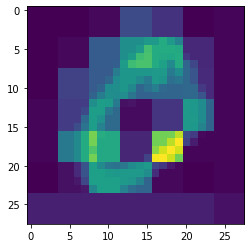

conv2d_2
(128, 4, 4)
7


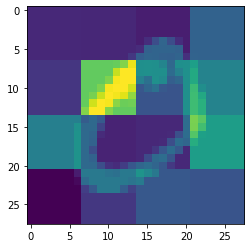

batch_normalization_1
(128, 4, 4)
7


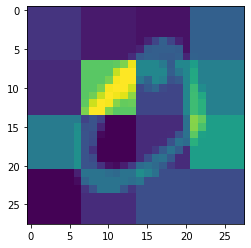

leaky_re_lu_2
(128, 4, 4)
7


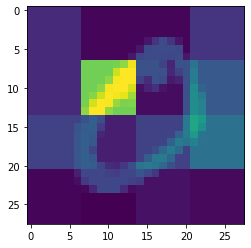

dropout
(128, 4, 4)
7


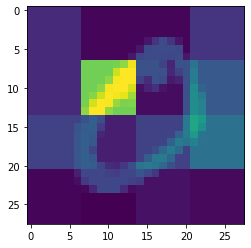

flatten


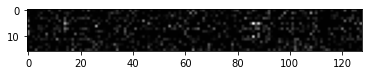

dense


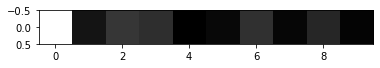

conv2d
(32, 14, 14)
2


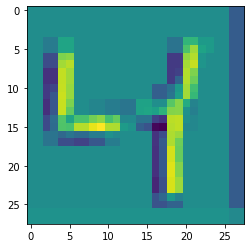

leaky_re_lu
(32, 14, 14)
2


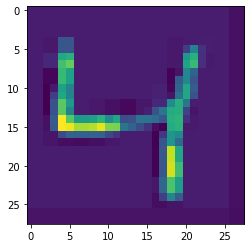

conv2d_1
(64, 7, 7)
4


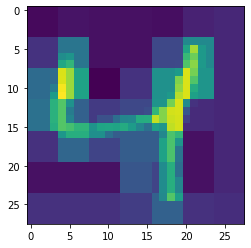

batch_normalization
(64, 7, 7)
4


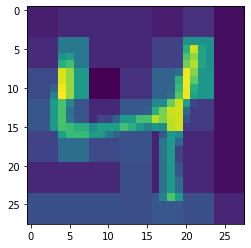

leaky_re_lu_1
(64, 7, 7)
4


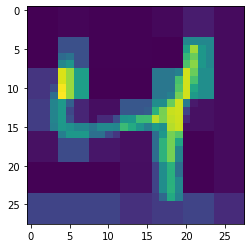

conv2d_2
(128, 4, 4)
7


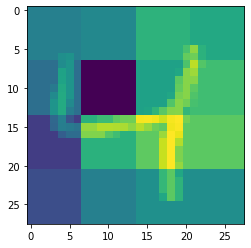

batch_normalization_1
(128, 4, 4)
7


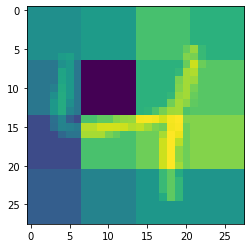

leaky_re_lu_2
(128, 4, 4)
7


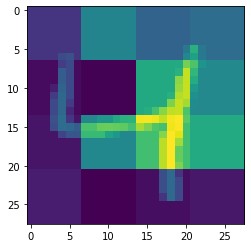

dropout
(128, 4, 4)
7


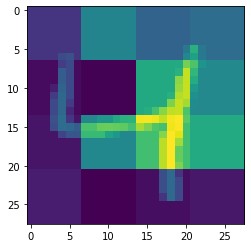

flatten


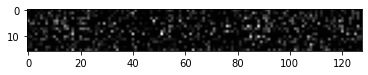

dense


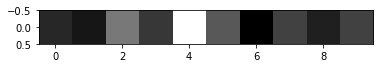

conv2d
(32, 14, 14)
2


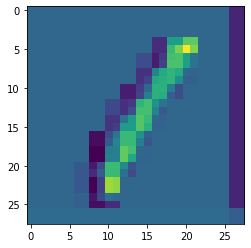

leaky_re_lu
(32, 14, 14)
2


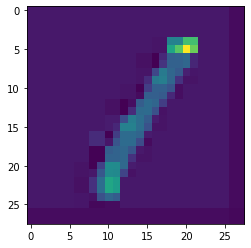

conv2d_1
(64, 7, 7)
4


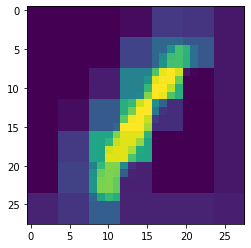

batch_normalization
(64, 7, 7)
4


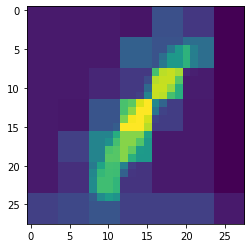

leaky_re_lu_1
(64, 7, 7)
4


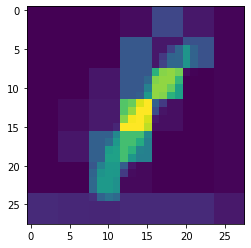

conv2d_2
(128, 4, 4)
7


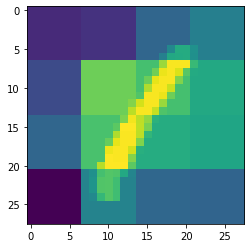

batch_normalization_1
(128, 4, 4)
7


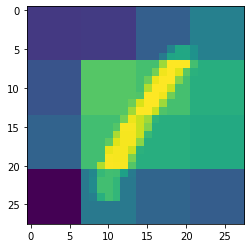

leaky_re_lu_2
(128, 4, 4)
7


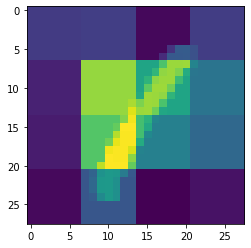

dropout
(128, 4, 4)
7


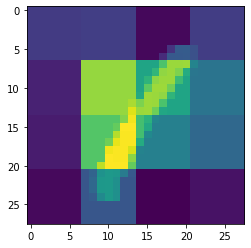

flatten


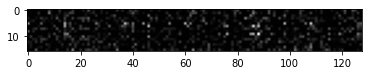

dense


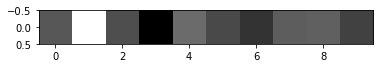

conv2d
(32, 14, 14)
2


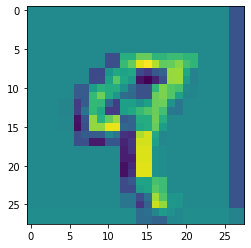

leaky_re_lu
(32, 14, 14)
2


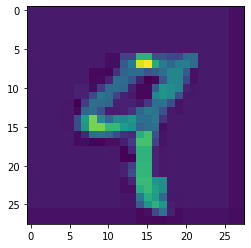

conv2d_1
(64, 7, 7)
4


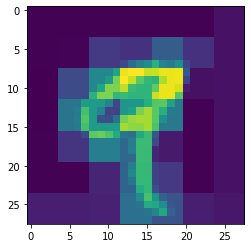

batch_normalization
(64, 7, 7)
4


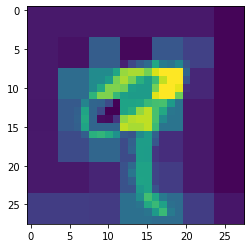

leaky_re_lu_1
(64, 7, 7)
4


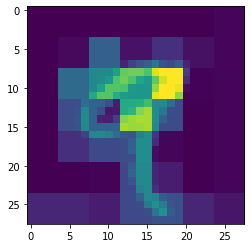

conv2d_2
(128, 4, 4)
7


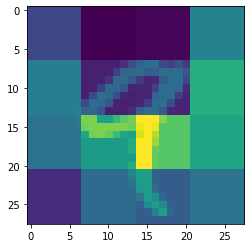

batch_normalization_1
(128, 4, 4)
7


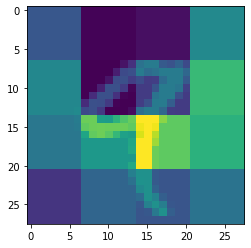

leaky_re_lu_2
(128, 4, 4)
7


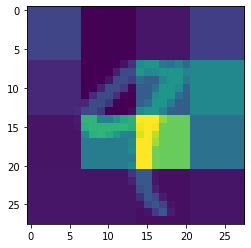

dropout
(128, 4, 4)
7


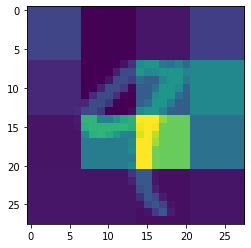

flatten


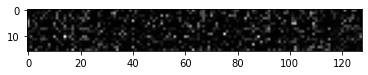

dense


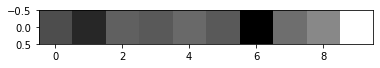

conv2d
(32, 14, 14)
2


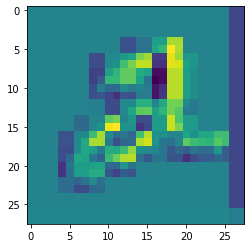

leaky_re_lu
(32, 14, 14)
2


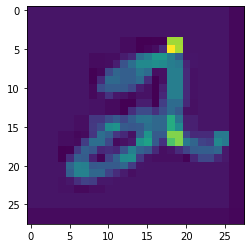

conv2d_1
(64, 7, 7)
4


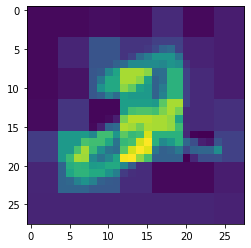

batch_normalization
(64, 7, 7)
4


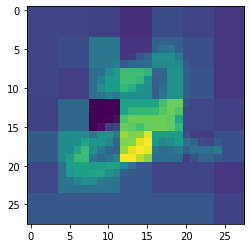

leaky_re_lu_1
(64, 7, 7)
4


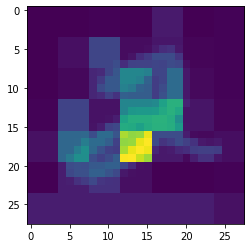

conv2d_2
(128, 4, 4)
7


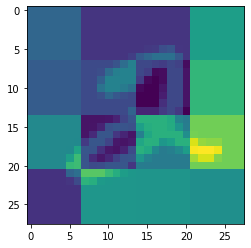

batch_normalization_1
(128, 4, 4)
7


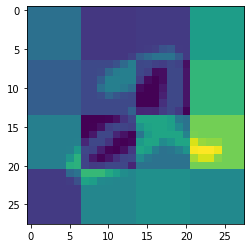

leaky_re_lu_2
(128, 4, 4)
7


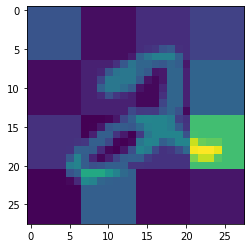

dropout
(128, 4, 4)
7


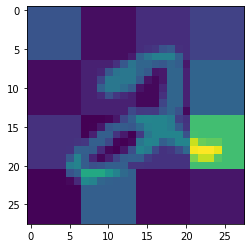

flatten


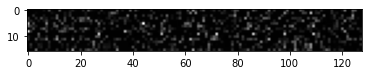

dense


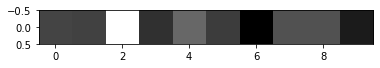

In [19]:
for i in range(5):
    show_hidden_outputs.marge_hidden_outputs(sgan.discriminator_supervised.layers[0],x_train[i + 1:i + 2,:,:,:])

In [20]:
sgan.generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

dense_1


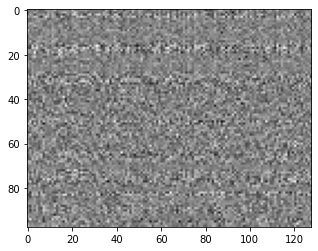

reshape
(256, 7, 7)
4


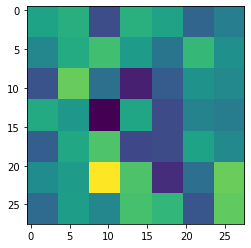

conv2d_transpose
(128, 14, 14)
2


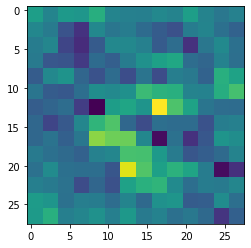

batch_normalization_2
(128, 14, 14)
2


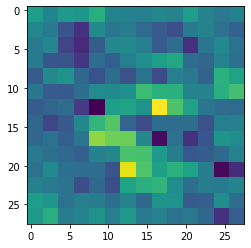

leaky_re_lu_3
(128, 14, 14)
2


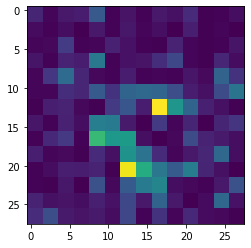

conv2d_transpose_1
(64, 14, 14)
2


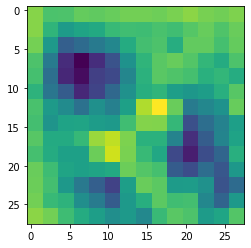

batch_normalization_3
(64, 14, 14)
2


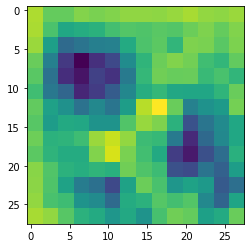

leaky_re_lu_4
(64, 14, 14)
2


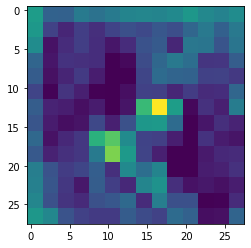

conv2d_transpose_2
(28, 28)
1


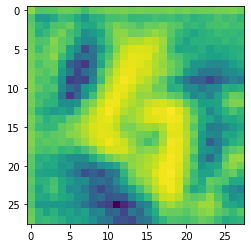

activation_1
(28, 28)
1


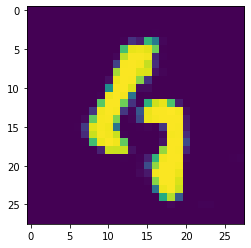

In [21]:
show_hidden_outputs.marge_hidden_outputs_generator(sgan.generator,tf.random.normal([1, 100]))

dense_1


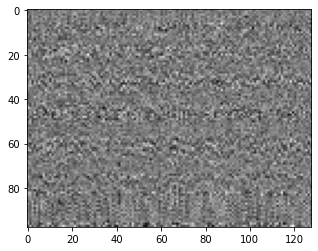

tf.Tensor([  1  98 128   1], shape=(4,), dtype=int32)
reshape
(256, 7, 7)
4


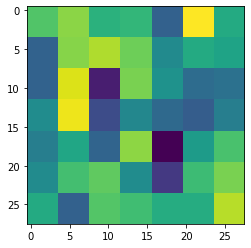

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
conv2d_transpose
(128, 14, 14)
2


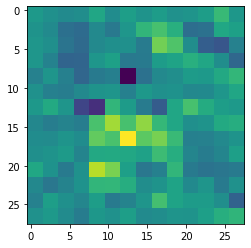

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
batch_normalization_2
(128, 14, 14)
2


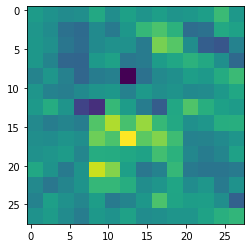

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
leaky_re_lu_3
(128, 14, 14)
2


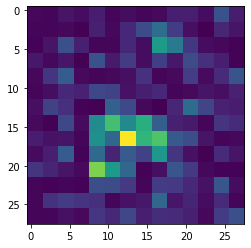

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
conv2d_transpose_1
(64, 14, 14)
2


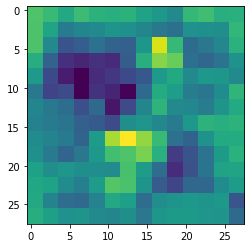

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
batch_normalization_3
(64, 14, 14)
2


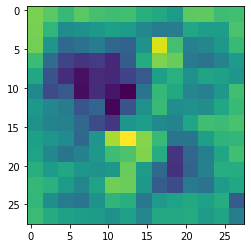

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
leaky_re_lu_4
(64, 14, 14)
2


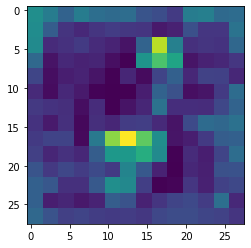

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
conv2d_transpose_2
(28, 28)
1


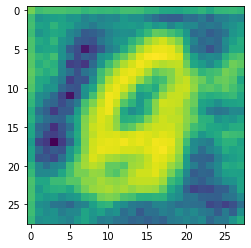

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)
activation_1
(28, 28)
1


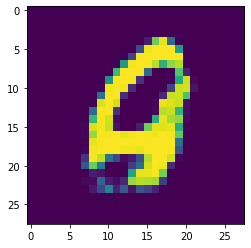

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)


In [22]:
import datetime
now = datetime.datetime.now() + datetime.timedelta(hours=9)
log_dir = "./logs/SGAN_getweights/" + now.strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(logdir=log_dir)
show_hidden_outputs.marge_hidden_outputs_generator(sgan.generator,tf.random.normal([1, 100]),summary_writer,0)

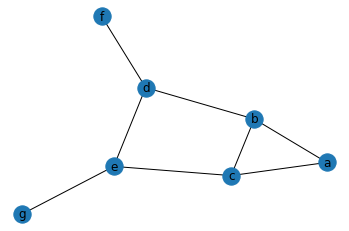

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#隣接行列
g = np.array([
    [1, 0, 1, 2],
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 2, 0]
])
nodes = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
G = nx.Graph()
G.add_nodes_from(nodes)
edges = []
for hi, hv  in enumerate(g):
    for wi, wv in enumerate(hv):
        if(wv): edges.append((nodes[hi], nodes[wi]))
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True)
plt.axis("off")
plt.show()